In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/oulu_cosmic.csv')
df

,Timestamp,FractionalDate,UncorrectedCountRate[cts/min],CorrectedCountRate[cts/min],Pressure[mbar]
0,2000-10-01T00:00:00Z,2000.748634,5251,5833,1013.52
1,2000-11-01T00:00:00Z,2000.833333,5169,5694,1012.04
2,2000-12-01T00:00:00Z,2000.915300,5501,5742,1004.83
3,2001-01-01T00:00:00Z,2001.000000,5313,5817,1011.37
4,2001-02-01T00:00:00Z,2001.084932,5551,5959,1008.95
5,2001-03-01T00:00:00Z,2001.161644,5721,6024,1006.01
6,2001-04-01T00:00:00Z,2001.246575,5389,5736,1007.54
7,2001-05-01T00:00:00Z,2001.328767,5480,5885,1008.61
8,2001-06-01T00:00:00Z,2001.413699,5575,5929,1007.23
9,2001-07-01T00:00:00Z,2001.495890,5536,5959,1008.88


In [3]:
#平滑化手法の定義
class FusedLasso:
    """
    pat 平滑化手法のパターン名
    0:abs(beta)
    1:abs(beta[i+1]-beta[i])
    2:abs(beta[i+2]-2*beta[i+1]+beta[i])
    3:abs(beta[i+3]-3*beta[i+2]+3*beta[i+1]-beta[i])
    """
    def __init__(self, y, beta, pat, lamb=500):
        self.y = y
        self.beta = beta
        self.lamb = lamb
        self.pat = pat # pattern 0,1,2,3から選択
        self.data_num = y.shape[0]
        self.coef = [[1], [1, -1], [1, -2, 1], [1, -3, 3, -1]]
        if self.pat == 0:
            #abs(beta)
            self.reg = self.beta
            self.sig = np.sign(self.reg)#
            self.value = 1/2*np.sum((self.y-self.beta)**2) + self.lamb*np.sum(self.sig*self.reg)
            self.grads  = -(self.y-self.beta) + self.lamb*(self.sig)
        elif self.pat == 1:
            #abs(beta[i+1]-beta[i])
            self.reg = np.diff(self.beta, axis=0) 
            self.sig = np.sign(self.reg)        
            self.sig_f = np.insert(self.sig, 0, 0, axis=0)
            self.sig_r = np.insert(self.sig, self.data_num-1, 0, axis=0)
            self.value = 1/2*np.sum((self.y-self.beta)**2) + self.lamb*np.sum(self.sig*self.reg)
            self.grads  = -(self.y-self.beta) + self.lamb*(self.sig_f-self.sig_r)
        elif self.pat == 2:
            #abs(beta[i+2]-2*beta[i+1]+beta[i])
            self.reg = np.array([self.beta[i+2]-2*self.beta[i+1]+self.beta[i] for i in range(self.beta.shape[0]-self.pat)])
            self.sig = np.sign(self.reg)
            self.sig1 = np.insert(self.sig, 0, [0,0], axis=0)
            temp = np.insert(self.sig, 0, 0, axis=0)
            self.sig2 = np.insert(temp,self.data_num-1,0,axis=0)
            self.sig3 = np.insert(self.sig,self.data_num-2,[0,0],axis=0)
            self.value = 1/2*np.sum((self.y-self.beta)**2) + self.lamb*np.sum(self.sig*self.reg)
            self.grads  = -(self.y-self.beta) + self.lamb*(self.sig1-2*self.sig2+self.sig3)
        elif self.pat == 3:
            #abs(beta[i+3]-3*beta[i+2]+3*beta[i+1]-beta[i])
            self.reg = np.array([self.beta[i+3]-3*self.beta[i+2]+3*self.beta[i+1]-self.beta[i] for i in range(self.beta.shape[0]-self.pat)])
            self.sig = np.sign(self.reg)
            self.sig1 = np.insert(self.sig, 0, [0,0,0], axis=0)
            temp = np.insert(self.sig, 0, [0,0], axis=0)
            self.sig2 = np.insert(temp,self.data_num-1,0,axis=0)
            temp = np.insert(self.sig, 0, 0, axis=0)
            self.sig3 = np.insert(temp,self.data_num-2,[0,0],axis=0)
            self.sig4 = np.insert(self.sig,self.data_num-3,[0,0,0],axis=0)
            self.value = 1/2*np.sum((self.y-self.beta)**2) + self.lamb*np.sum(self.sig*self.reg)
            self.grads  = -(self.y-self.beta) + self.lamb*(self.sig1-3*self.sig2+3*self.sig3-self.sig4)
        else :
            print("errorrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr")        
            
    def calc_value(self):
        return self.value
    def calc_grads(self):
        return self.grads

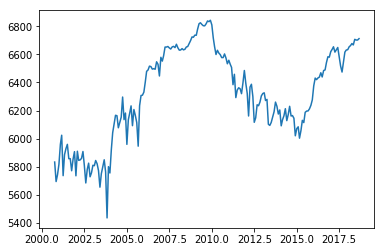

In [4]:
#平滑化するデータの選択
x = df["FractionalDate"].values
y = df["CorrectedCountRate[cts/min]"].values
plt.plot(x, y)

In [5]:
#パラメータ設定
lr = 0.0001 # 学習率
cnts = 50000 # 計算回数
lamb = 500 # 平滑化パラメータ

In [6]:
#平滑化
val_list = []
beta_list= []
for pat in range(4):
    beta = np.random.normal(6000, 100, len(df))#初期値（適当）
    val = []
    for cnt in range(cnts):
        fl = FusedLasso(y, beta, pat, lamb)
        temp_val = fl.calc_value()
        beta -= lr * fl.calc_grads()        
        val.append(temp_val)
    val_list.append(val)
    beta_list.append(beta)
    

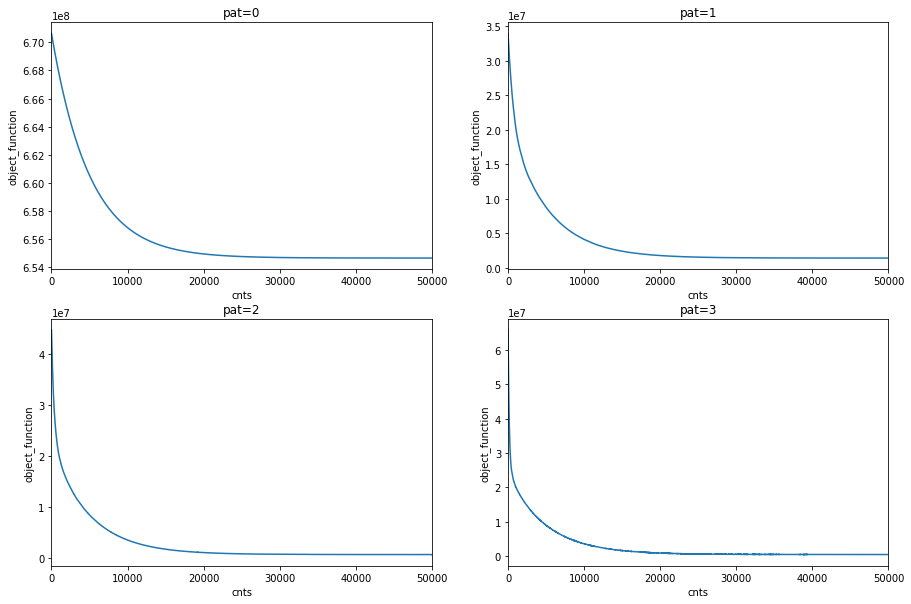

In [7]:
#目的関数の推移
plt.figure(figsize=(15,10))
titles = ["pat=0", "pat=1", "pat=2", "pat=3"]
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(range(cnts), val_list[i][:])
    plt.title(titles[i])
    plt.xlabel('cnts')
    plt.ylabel('object_function')
    plt.xlim([0, cnts])
    #plt.ylim([0, 800000000])
    """
    if i ==0:
        plt.ylim([0, 800000000])
    else:
        plt.ylim([0, 40000000])
    """    

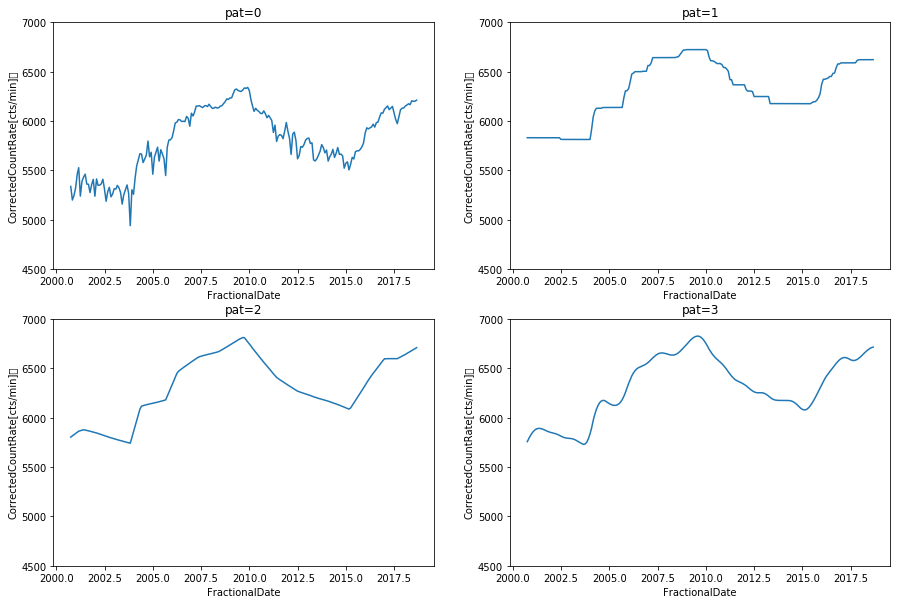

In [8]:
#結果の描画
plt.figure(figsize=(15,10))
titles = ["pat=0", "pat=1", "pat=2", "pat=3"]
for i in range(4):
    plt.subplot(2, 2, i+1)
    #plt.plot(x, y)
    plt.plot(x, beta_list[i][:])
    plt.title(titles[i])
    plt.xlabel('FractionalDate')
    plt.ylabel('CorrectedCountRate[cts/min]	')
    #plt.xlim([0, cnts])
    plt.ylim([4500, 7000])

In [9]:
#平滑化手法の定義
#一括でpat：0,1,2,3を書こうとしたが、for文が多くなりすぎて計算がおそすぎる（未完成）
class BotsuFusedLasso:
    """
    pat 平滑化手法のパターン名
    0:abs(beta)
    1:abs(beta[i+1]-beta[i])
    2:abs(beta[i+2]-2*beta[i+1]-beta[i])
    3:abs(beta[i+3]-3*beta[i+2]+3*beta[i+1]-beta[i])
    """
    def __init__(self,y,beta,pat,lamb=500):
        self.y = y
        self.beta = beta
        self.lamb = lamb
        self.pat = pat#pattern 0,1,2,3から選択
        self.data_num = y.shape[0]
        
        self.coef = [np.array([1]),np.array([1,-1]),np.array([1,-2,1]),np.array([1,-3,3,-1])]
        self.diff = [np.zeros(self.beta.shape[0]-self.coef[i].shape[0]+1) for i in range(4)]
        for i in range(len(self.coef)):
            for j in range(self.beta.shape[0]-self.coef[i].shape[0]+1):
                s = 0
                for k in range(self.coef[i].shape[0]):
                    s += self.coef[i][k]*self.beta[j+k]
                self.diff[i][j] = s
        temp_sig = np.sign(self.diff[self.pat])
        self.final_sig = np.zeros((self.pat+1, self.beta.shape[0]))
        for i in range(self.final_sig.shape[0]):
            self.final_sig[i][:] = np.insert(np.zeros(self.pat), i, temp_sig, axis=0)
            #self.final_sig[i][:] = np.insert(np.zeros(self.pat), self.final_sig.shape[0]-1- i, temp_sig, axis=0)
        self.reg = np.array([self.coef[self.pat][i]*self.final_sig[i][:] for i in range(self.coef[pat].shape[0])])        
        self.value = 1/2*np.sum((self.y - self.beta)**2) + self.lamb*np.sum(temp_sig*self.diff[self.pat])
        self.grads = -(self.y - self.beta) + self.lamb*np.sum(self.reg,axis=0)
            
    def calc_value(self):
        return self.value
    def calc_grads(self):
        return self.grads
